# Smoothing Required for a Good Coarsening $P$
We expect to need smoother TVs for $P$ than for $R$.

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [2]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

symmetrize = False # True
repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 5

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0->1 Coarsening

In [3]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n).tocsr()
# Use default = Kacmzarz relaxation for kh != 0.
level0 = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None, symmetrize=symmetrize)
# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level0.location = np.arange(n)

### Coarsening

In [4]:
def create_coarsening(level, nu, aggregate_size, num_components):
    # Generate relaxed test vectors.
    x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
    _LOGGER.info("Generating relaxed TF with {} sweeps, RER {:.3f}".format(nu, norm(level.a.dot(x)) / norm(x)))
    #x_log.append(x)

    # Create coarsening. Force 2 coarse vars per aggregate so we can test alignment.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    R = r.tile(level.size // aggregate_size)
    return x, R

In [5]:
# Check Relaxation smoothing.
num_sweeps = hm.setup.auto_setup.check_relaxation_speed(0, level0)[1]
aggregate_size, num_components = 4, 2
x, R = create_coarsening(level0, 2 * num_sweeps, aggregate_size, num_components)

INFO     level 0 size 96 relax conv 0.94 shrinkage 0.38 PODR RER 0.70 after 2 sweeps. Work 1.0 eff 0.38
INFO     Generating relaxed TF with 4 sweeps, RER 0.367


### Coarsening Performance
Mock cycle convergnce factors below are shown as a function of
* Table = $\nu$ = number of relaxations per coarse-level correction in the mock cycle.
* Rows = $\nu_{TF}$ = number of relaxations performed on TFs.
* Columns = $s$ = number of samples (windows) used in SVD.

In [6]:
def mock_cycle_conv(level,
                    aggregate_size: int,
                    num_components: int,
                    num_cycle_sweeps: np.ndarray,
                    num_tf_sweeps: int,
                    num_windows: int,
                    seed: int = 0,
                    weighted: bool = True):  # List[Tuple[caliber: int, r_restrict: int, symmetrize: int]] 
    np.random.seed(seed)
    # Create test functions.
    x = hm.analysis.ideal.ideal_tv(level.a, num_examples)[0] if num_tf_sweeps == -1 \
                          else hm.setup.auto_setup.get_test_matrix(level.a, num_tf_sweeps, num_examples=num_examples)
    
    # Create R, measure mock cycle rates.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False, 
                                                    num_windows=num_windows)
    R = r.tile(level.size // aggregate_size)
    return [hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in num_cycle_sweeps]

In [7]:
seed = 0
num_cycle_sweeps = np.arange(1, num_sweeps + 4)
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 7)))
num_windows = np.concatenate(([2, 3], 2 ** np.arange(2, 8)))
mock_conv = np.array([[mock_cycle_conv(
    level0, aggregate_size, num_components, num_cycle_sweeps,
    nu, s, weighted=weighted, seed=seed)
                for s in num_windows]
                for nu in num_tf_sweeps])

for col, nu_cycle in enumerate(num_cycle_sweeps):
    print("# Relax per cycle {}".format(nu_cycle))
    display(pd.DataFrame(mock_conv[:, :, col], index=num_tf_sweeps, columns=num_windows))

# Relax per cycle 1


,2,3,4,8,16,32,64,128
0,0.8060,0.6617,0.6632,0.8229,0.9018,0.9225,0.9284,0.8445
2,0.5071,0.5105,0.5076,0.5041,0.5072,0.5049,0.5074,0.5078
4,0.5040,0.5050,0.5053,0.5035,0.5089,0.5064,0.5092,0.5093
8,0.5053,0.5056,0.5074,0.5071,0.5116,0.5085,0.5104,0.5106
16,0.5068,0.5070,0.5093,0.5080,0.5124,0.5108,0.5114,0.5114
32,0.5090,0.5086,0.5101,0.5048,0.5108,0.5112,0.5116,0.5113
64,0.5129,0.5095,0.5150,0.5056,0.5101,0.5110,0.5114,0.5112


# Relax per cycle 2


,2,3,4,8,16,32,64,128
0,0.7237,0.5507,0.5523,0.7429,0.8205,0.8463,0.8859,0.8111
2,0.2880,0.2793,0.2758,0.2729,0.2769,0.2786,0.2802,0.2842
4,0.2764,0.2755,0.2736,0.2729,0.2777,0.2805,0.2801,0.2813
8,0.2788,0.2774,0.2754,0.2765,0.2777,0.2804,0.2796,0.2798
16,0.2805,0.2799,0.2768,0.2790,0.2786,0.2801,0.2796,0.2798
32,0.2807,0.2816,0.2774,0.2801,0.2800,0.2804,0.2805,0.2807
64,0.2781,0.2852,0.2692,0.2801,0.2809,0.2823,0.2830,0.2831


# Relax per cycle 3


,2,3,4,8,16,32,64,128
0,0.6891,0.5066,0.5047,0.7088,0.8041,0.8288,0.8510,0.7462
2,0.1703,0.2080,0.1972,0.1889,0.1774,0.1806,0.1676,0.1660
4,0.1868,0.1985,0.1982,0.2021,0.1815,0.1794,0.1718,0.1712
8,0.1785,0.1841,0.1890,0.1936,0.1832,0.1785,0.1745,0.1743
16,0.1764,0.1777,0.1828,0.1916,0.1834,0.1780,0.1756,0.1754
32,0.1741,0.1726,0.1769,0.2014,0.1821,0.1766,0.1746,0.1745
64,0.1664,0.1644,0.1960,0.1882,0.1768,0.1734,0.1720,0.1722


# Relax per cycle 4


,2,3,4,8,16,32,64,128
0,0.6476,0.4857,0.4854,0.6871,0.7795,0.8060,0.8352,0.7126
2,0.1169,0.1540,0.1323,0.1165,0.0977,0.1218,0.1101,0.1116
4,0.1134,0.1252,0.1266,0.1289,0.0963,0.1198,0.1081,0.1102
8,0.1166,0.1063,0.1158,0.1232,0.1065,0.1108,0.1032,0.1040
16,0.1154,0.1137,0.1049,0.1127,0.1041,0.1013,0.1002,0.1018
32,0.1096,0.1126,0.0900,0.1294,0.0930,0.1043,0.1058,0.1070
64,0.0981,0.1091,0.1751,0.1237,0.1094,0.1113,0.1112,0.1115


# Relax per cycle 5


,2,3,4,8,16,32,64,128
0,0.6296,0.4682,0.4626,0.6625,0.7585,0.7815,0.8163,0.7032
2,0.0775,0.1459,0.1324,0.1176,0.1008,0.0863,0.0789,0.0578
4,0.1139,0.1335,0.1340,0.1349,0.1060,0.0779,0.0837,0.0794
8,0.0913,0.1084,0.1202,0.1267,0.1081,0.0888,0.0884,0.0876
16,0.0837,0.0878,0.1094,0.1191,0.1067,0.0918,0.0897,0.0889
32,0.0851,0.0776,0.0988,0.1198,0.1020,0.0889,0.0861,0.0854
64,0.0847,0.0602,0.1616,0.0921,0.0865,0.0786,0.0708,0.0701


As can be seen, even two relaxation sweps are sufficient to obtain a good coarsening, if there are enough samples; or, relaxing more (at least 8 sweeeps) with only 4 (!) windows is enough to good coarsening.

In [8]:
for l, nu in enumerate(num_cycle_sweeps):
    ideal = mock_conv[-1, -1, l]
    i, j = np.where(mock_conv[:, :, l] < 1.3 * ideal)
    work = np.maximum(num_tf_sweeps[i], 1) * num_windows[j]
    best = np.argmin(work)
    print(nu, num_tf_sweeps[i[best]], num_windows[j[best]], work[best], mock_conv[i[best], j[best], l])

1 0 3 3 0.661723369714742
2 2 2 4 0.2879906746622042
3 2 2 4 0.1703060786342351
4 2 2 4 0.11687073378992684
5 2 2 4 0.07752444180679667


### Interpolation Performance

In [81]:
def two_level_performance(level, 
                          aggregate_size: int,
                          num_components: int,
                          max_cycle_sweeps: int,
                          num_tf_sweeps: int,
                          num_windows: int,
                          coarsening_types,
                          seed: int = 0,
                          weighted: bool = True):  # List[Tuple[caliber: int, r_restrict: int, symmetrize: int]] 
    np.random.seed(seed)
    num_cycle_sweeps = np.arange(1, max_cycle_sweeps + 1)
    # Create test functions.
    x = hm.analysis.ideal.ideal_tv(level.a, num_examples)[0] if nu == -1 \
                          else hm.setup.auto_setup.get_test_matrix(level.a, num_tf_sweeps, num_examples=num_examples)
    
    # Create R, measure mock cycle rates.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False, num_windows=num_windows)
    R = r.tile(level.size // aggregate_size)
    # TODO: replace by local mock cycle rate.
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in num_cycle_sweeps])

    l2c = []
    p_values = []
    for caliber, r_restrict, symmetrize in coarsening_types:
        # Create P, A^c, and a two-level hierarchy.
        p = hm.setup.auto_setup.create_interpolation(
            x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted, num_windows=num_windows)
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
            use_r_as_restriction=r_restrict, symmetrize=symmetrize)
        
        # Measure convergence and operator stats.
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in num_cycle_sweeps])
        l2c.append([False, caliber, r_restrict, symmetrize, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_values.append(p)
    return pd.DataFrame(np.array([[True, 0, False, False, 0, 0, False] + list(mock_conv)] + l2c),
        columns=("mock", "caliber", "r-restrict", "symmetrize", "nnz(P)", "Fill-in", "Symmetry") + tuple(num_cycle_sweeps)).astype(
        {"mock": bool, "caliber": int, "r-restrict": bool, "symmetrize": bool, "nnz(P)": int}), x, R, p_values

In [96]:
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 7)))
num_windows = 64
coarsening_types = [
    (4, False, False),
    (4, True, False),
    (4, True, True)
]

# seed=13 - RAP symmetrized strongly diverges.
seed = 13
#for seed in range(13, 14):
#    print("seed", seed)
for num_tf_sweeps in np.concatenate(([0], 2 ** np.arange(1, 7))):
    print("num_tf_sweeps", num_tf_sweeps)
    conv, x, R, p_values = two_level_performance(level0, aggregate_size, num_components, num_sweeps + 3,
                                                 num_tf_sweeps, num_windows, coarsening_types, 
                                                 weighted=weighted, seed=seed)
    display(conv)

num_tf_sweeps 0


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5
0,True,0,False,False,0,0.0000,0.0000,0.7711,0.6977,0.6636,0.6311,0.5949
1,False,4,False,False,384,2.0000,0.0000,1.1135,1.1207,1.0972,1.0656,1.0313
2,False,4,True,False,384,1.2000,0.7572,1.4882,1.5982,1.6032,1.5727,1.5310
3,False,4,True,True,384,1.2000,0.0000,1.5406,1.6827,1.7005,1.6750,1.6345


num_tf_sweeps 2


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5
0,True,0,False,False,0,0.0000,0.0000,0.5408,0.3005,0.1819,0.1134,0.0805
1,False,4,False,False,384,2.0000,0.0000,0.5118,0.2794,0.2449,0.2754,0.2984
2,False,4,True,False,384,1.2000,0.0342,0.4668,0.2900,0.2225,0.2146,0.2166
3,False,4,True,True,384,1.2000,0.0000,0.4883,0.2858,0.2118,0.1680,0.1402


num_tf_sweeps 4


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5
0,True,0,False,False,0,0.0000,0.0000,0.5363,0.2950,0.1758,0.1083,0.0735
1,False,4,False,False,384,2.0000,0.0000,0.5145,0.2659,0.1377,0.0777,0.0556
2,False,4,True,False,384,1.2000,0.0056,0.4803,0.2839,0.1798,0.1314,0.1038
3,False,4,True,True,384,1.2000,0.0000,0.5022,0.2797,0.1803,0.1304,0.1040


num_tf_sweeps 8


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5
0,True,0,False,False,0,0.0000,0.0000,0.5314,0.2890,0.1711,0.1075,0.0624
1,False,4,False,False,384,2.0000,0.0000,0.5185,0.2693,0.1417,0.0841,0.0548
2,False,4,True,False,384,1.2000,0.0056,0.4955,0.2783,0.1647,0.1092,0.0814
3,False,4,True,True,384,1.2000,0.0000,0.5098,0.2594,0.1664,0.1056,0.0838


num_tf_sweeps 16


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5
0,True,0,False,False,0,0.0000,0.0000,0.5284,0.2853,0.1705,0.1092,0.0596
1,False,4,False,False,384,2.0000,0.0000,0.5196,0.2694,0.1439,0.0875,0.0594
2,False,4,True,False,384,1.2000,0.0025,0.5009,0.2695,0.1528,0.0834,0.0651
3,False,4,True,True,384,1.2000,0.0000,0.5113,0.2555,0.1524,0.0789,0.0619


num_tf_sweeps 32


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5
0,True,0,False,False,0,0.0000,0.0000,0.5275,0.2842,0.1709,0.1100,0.0629
1,False,4,False,False,384,2.0000,0.0000,0.5189,0.2682,0.1444,0.0905,0.0632
2,False,4,True,False,384,1.2000,0.0084,0.4993,0.2536,0.1316,0.0747,0.0612
3,False,4,True,True,384,1.2000,0.0000,0.5109,0.2535,0.1284,0.0699,0.0633


num_tf_sweeps 64


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5
0,True,0,False,False,0,0.0000,0.0000,0.5276,0.2843,0.1713,0.1104,0.0625
1,False,4,False,False,384,2.0000,0.0000,0.5179,0.2675,0.1428,0.0891,0.0621
2,False,4,True,False,384,1.2000,0.0036,0.4847,0.2825,0.1690,0.0862,0.0674
3,False,4,True,True,384,1.2000,0.0000,2.4042,1.3164,0.7099,0.4492,0.3176


With $s = 32$ windows:
8 $P^T A P$ gives good rated with with only $4$ TF sweeps. 
* $8$ are required to get a good $R A P$.
* Symmetrizing $R A P$ requires at least $32$ sweeps, although even then the cycle diverges for $\nu=1$. But it alo diverges for $R A P$, so symmetrizing is not necessarily the culprit; it just amplifies divergece when it's present.

One idea is to employ two-level bootstrap with $P^T A P$ and only at the end of processing 

#### Symmetrized $R A P$ Performance vs. $\nu_{TF}, s$

In [83]:
def two_level_conv(level, 
                    aggregate_size: int,
                    num_components: int,
                    num_cycle_sweeps: np.ndarray,
                    num_tf_sweeps: int,
                    num_windows: int,
                    coarsening_type,
                    seed: int = 0,
                    weighted: bool = True):  # List[Tuple[caliber: int, r_restrict: int, symmetrize: int]] 
    np.random.seed(seed)
    # Create test functions.
    x = hm.analysis.ideal.ideal_tv(level.a, num_examples)[0] if nu == -1 \
                          else hm.setup.auto_setup.get_test_matrix(level.a, num_tf_sweeps, num_examples=num_examples)
    
    # Create R, measure mock cycle rates.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False, 
                                                    num_windows=num_windows)
    R = r.tile(level.size // aggregate_size)

    caliber, r_restrict, symmetrize = coarsening_type
    # Create P, A^c, and a two-level hierarchy.
    p = hm.setup.auto_setup.create_interpolation(
        x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
        neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
        caliber=caliber, fit_scheme=fit_scheme, weighted=weighted, num_windows=num_windows)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, R, p, aggregate_size, num_components,
        use_r_as_restriction=r_restrict, symmetrize=symmetrize)

    return[
        hm.repetitive.locality.two_level_conv_factor(
            ml, nu, print_frequency=None)[1]
         for nu in num_cycle_sweeps]

In [84]:
num_cycle_sweeps = np.arange(1, num_sweeps + 4)
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 7)))
num_windows = 2 ** np.arange(4, 8)

coarsening_type = (4, True, True)

conv = np.array([[two_level_conv(
    level0, aggregate_size, num_components, num_cycle_sweeps,
        nu, s, coarsening_type, weighted=weighted, seed=seed)
                for s in num_windows]
                for nu in num_tf_sweeps])

for col, nu_cycle in enumerate(num_cycle_sweeps):
    print("# Relax per cycle {}".format(nu_cycle))
    display(pd.DataFrame(conv[:, :, col], index=num_tf_sweeps, columns=num_windows))

# Relax per cycle 1


,16,32,64,128
0,0.9761,1.0015,1.5456,1.8078
2,0.9379,0.5299,0.4817,0.4491
4,0.5355,0.5233,0.4996,0.5021
8,0.5192,1.5435,0.5120,0.5207
16,0.5153,0.5120,0.5144,0.5220
32,0.5097,0.4786,0.5235,0.5177
64,68.2950,1.8444,2.3781,0.4988


# Relax per cycle 2


,16,32,64,128
0,0.9506,0.9877,1.6826,1.9873
2,0.4116,0.3014,0.2703,0.2824
4,0.3301,0.3128,0.2842,0.2918
8,0.4003,0.7847,0.2817,0.3010
16,0.2759,0.2758,0.2747,0.2949
32,0.2672,0.2562,0.2597,0.2836
64,39.9384,0.7653,1.3297,0.2647


# Relax per cycle 3


,16,32,64,128
0,0.9350,0.9662,1.7004,2.0009
2,0.2957,0.2237,0.2002,0.1835
4,0.3770,0.2136,0.1797,0.1951
8,0.4645,0.5145,0.1669,0.1965
16,0.1488,0.1557,0.1543,0.1831
32,0.1337,0.1361,0.1327,0.1674
64,27.8404,0.4783,0.7419,0.1459


# Relax per cycle 4


,16,32,64,128
0,0.9196,0.9452,1.6758,1.9631
2,0.2447,0.1931,0.1603,0.1406
4,0.3840,0.1652,0.1316,0.1471
8,0.4772,0.3600,0.1117,0.1453
16,0.1243,0.1003,0.0903,0.1274
32,0.1419,0.0765,0.0719,0.1077
64,22.7347,0.5565,0.4433,0.0682


# Relax per cycle 5


,16,32,64,128
0,0.9104,0.9164,1.6348,1.9096
2,0.2094,0.1872,0.1500,0.1096
4,0.3726,0.1372,0.1062,0.1191
8,0.4680,0.2795,0.0839,0.1163
16,0.1266,0.0758,0.0639,0.0975
32,0.1419,0.0506,0.0640,0.0783
64,16.5033,0.5590,0.2996,0.0550


In [85]:
for l, nu in enumerate(num_cycle_sweeps):
    ideal = conv[-1, -1, l]
    i, j = np.where(conv[:, :, l] < 1.3 * ideal)
    work = np.maximum(num_tf_sweeps[i], 1) * num_windows[j]
    best = np.argmin(work)
    print(nu, num_tf_sweeps[i[best]], num_windows[j[best]], work[best], mock_conv[i[best], j[best], l])

1 2 32 64 0.5105345454840166
2 2 32 64 0.27932997364623
3 2 128 256 0.18886358564328334
4 32 32 1024 0.11257695199079426
5 16 64 1024 0.10944915853725322


## Notes
* The product of smoothing * samples is still the important factor for good convergence.
* Looks like adding windows is more beneficial than adding smoothing.

### Create Level 1

INFO         0 |r| 1.704e+01 RER 3.13611
INFO         1 |r| 3.371e+00 (0.19787) RER 0.02634 (0.00840) 127.969
INFO         2 |r| 2.013e+00 (0.59723) RER 0.03601 (1.36724) 55.898
INFO         3 |r| 9.452e-01 (0.46953) RER 0.01195 (0.33193) 79.071
INFO         4 |r| 4.010e-01 (0.42419) RER 0.00519 (0.43441) 77.210
INFO         5 |r| 2.188e-01 (0.54580) RER 0.00308 (0.59376) 70.973
INFO         6 |r| 1.533e-01 (0.70053) RER 0.00199 (0.64582) 76.985
INFO         7 |r| 9.676e-02 (0.63113) RER 0.00132 (0.66346) 73.234
INFO         8 |r| 5.076e-02 (0.52457) RER 0.00068 (0.51285) 74.907
INFO         9 |r| 2.241e-02 (0.44162) RER 0.00030 (0.44417) 74.476
INFO        10 |r| 9.979e-03 (0.44519) RER 0.00013 (0.44580) 74.375
INFO        11 |r| 6.323e-03 (0.63360) RER 0.00008 (0.63173) 74.596
INFO        12 |r| 4.352e-03 (0.68832) RER 0.00006 (0.68992) 74.422
INFO        13 |r| 2.555e-03 (0.58720) RER 0.00003 (0.58645) 74.517
INFO        14 |r| 1.245e-03 (0.48713) RER 0.00002 (0.48737) 74.481
INFO  

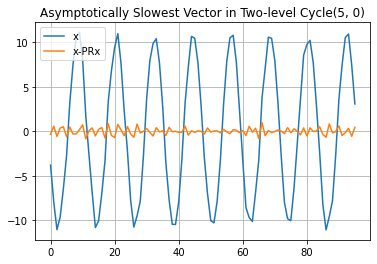

In [86]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P and RAP.

caliber = 4
num_windows = None
use_r_as_restriction = True #False
symmetrize = True # False
nu_tf = 64

p = p_values[0]
# x = hm.analysis.ideal.ideal_tv(level0.a, num_examples)[0] if nu_tf == -1 \
#     else hm.setup.auto_setup.get_test_matrix(level0.a, nu_tf, num_examples=num_examples)

# # Create R, measure mock cycle rates.
# r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False, num_windows=num_windows)
# R = r.tile(level0.size // aggregate_size)

# p = hm.setup.auto_setup.create_interpolation(
#     x, level0.a, R, level0.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
#     neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
#     caliber=caliber, fit_scheme=fit_scheme, weighted=weighted, num_windows=num_windows)

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level0.a, level0.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction,
    symmetrize=symmetrize)

nu = 5
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({}, 0)".format(nu))
# y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");

plt.grid(True);
plt.legend();

In [87]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [ 0.     0.     0.064  0.064 -0.072 -0.072  0.119  0.119 -0.151 -0.151  0.165  0.165]


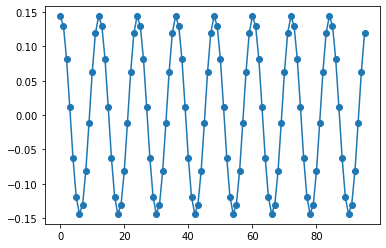

In [101]:
plt.plot(vl_finest[0][:, 0], '-o')

## TODO

* Try ideal vectors.
* Do relaxations to generate an initial $P$.
* Bootstrap is for identifying slow-to-converge components and improve $P$ for them.
* $8$ TF sweeps only - what is the initial cycle rate? Does it have good shrinkage? Even if asymptotic rate is bad.
* Compare first mock cycle rates vs. 2-level cycle rates.
* Check if divergence is because the last cycles ar bad but before were good.
* Add orthogonalization / Ritz projection - does the result improve with more relax sweeps then?
* Do we need to regularize?
* Try larger domain, at which # relax does the problem start? Is it domain size dependent?

In [88]:
# p = p_experiment[True][-1]

In [89]:
# # TODO(orenlivne): define error as (x-x0) projected onto range(a).
# nu = 2
# use_r_as_restriction = False
# p = p_experiment[use_r_as_restriction][-1]  # P^T*A*P P high order
# use_r_as_restriction = use_r_as_restriction

# m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
#     level1.a, level1.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

# y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
#                                                     debug=False)

# # Asymptotic vector.
# plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# # y -= y.mean() # Remove zero component.
# e = y - m1[1].interpolate(m1[1].coarsen(y))
# plt.plot(y, label="x");
# plt.plot(e, label="x-PRx");
# plt.grid(True);
# plt.legend();

In [105]:
m0[0].a.todense()

matrix([[-2.226,  1.333, -0.083,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.083,  1.333],
        [ 1.333, -2.226,  1.333, -0.083,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0. 